# Overview
The data science lifecycle is designed for big data issues and the data science projects. Generally, the data science project consists of seven steps which are problem definition, data collection, data preparation, data exploration, data modeling, model evaluation and model deployment.

# Importation of Libraries
imports necessary libraries for data manipulation, visualization, machine learning model building, evaluation, and interpretability. It then loads the dataset from a CSV file named 'data.csv' into a pandas DataFrame.
This is the crucial first step in evaluation of machine learning project. Loading the data allows us to begin exploring and preparing it to build a model that can predict heart disease.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, recall_score, log_loss, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
import shap
from sklearn.preprocessing import OneHotEncoder
import time

## Data Exploration

In [2]:
# Load dataset
df = pd.read_csv('data.csv')

This gives a snapshot of the data structure and the types of values in each column.
Examining the head of the dataset allows us to see the different features (patient attributes) that will be used to predict the target variable (presence of heart disease). We can see examples of numerical data (age, trestbps, chol, thalach, oldpeak) and what appear to be categorical or encoded data (sex, cp, fbs, restecg, exang, slope, ca, thal, target). The 'target' variable seems to have values like 1 and 2, which likely represent the absence or presence of heart disease, respectively (this is confirmed later in the code).

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,2
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,1
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,2
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,1
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,1


Generates descriptive statistics for the numerical columns in the DataFrame, such as count, mean, standard deviation, minimum, maximum, and quartiles. 

In [4]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296,1.444444
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659,0.497827
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000,1.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000,1.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000,1.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000,2.000000


This provides valuable insights into the distribution and range of the numerical features. For example, we can see the average age of patients in the dataset, the range of cholesterol levels, and the typical resting blood pressure. This helps in understanding the characteristics of the patient population and identifying potential outliers or issues with the data. The mean of the 'target' variable being around 1.44 suggests an imbalance in the classes (more patients without heart disease than with, assuming 1 is no disease and 2 is disease, which is clarified later).

# Data Preprocessed

In [5]:
# Check for missing values
print("Missing values in dataset:\n", df.isnull().sum())

Missing values in dataset:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


The output shows that there are no missing values in the dataset. This is ideal, as missing data can complicate model training and require imputation or removal, which might introduce bias or lose information. Having no missing values means the dataset is clean in this regard and ready for further processing.

# Encoding Process

It maps the original value of 1 to 0 (representing no heart disease) and the original value of 2 to 1 (representing the presence of heart disease).

In [6]:
# Recode target variable (1 -> 0: no disease, 2 -> 1: disease based on sample interpretation)
df['target'] = df['target'].map({1: 0, 2: 1})

This step is essential for preparing the target variable for binary classification models, which typically expect the target to be represented by 0s and 1s. The mapping aligns the target variable with standard machine learning conventions for binary outcomes.

Oneot encoding converts categorical variables into a numerical format that machine learning models can understand. drop_first=True is used to avoid multicollinearity.   

In [7]:
# One-hot encode categorical variables
categorical_cols = ['cp', 'restecg', 'slope', 'ca', 'thal']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

Categorical features like chest pain type (cp) or the results of the resting electrocardiographic measurement (restecg) are important for predicting heart disease, but models cannot directly use non-numerical values. One-hot encoding creates new binary columns for each category within these features, allowing the models to incorporate this information effectively. Dropping the first category helps prevent the dummy variable trap.

# Data Splitting and Handling Imbalance

Splits the encoded DataFrame into features (X) and the target variable (y).  It then splits the data into training and testing sets using a test size of 20% and a random_state for reproducibility.

In [8]:
# Split data into features and target
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Splitting the data is a standard practice to evaluate how well a trained model generalizes to unseen data. The training set is used to train the model, and the test set is used to assess its performance on new patients. A test size of 20% is reasonable for this dataset size.

# Class Imbalance Handle

Applied the Synthetic Minority Over-sampling Technique (SMOTE) to the training data.  SMOTE is an oversampling technique that creates synthetic samples of the minority class (likely the heart disease cases) to balance the class distribution

In [10]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

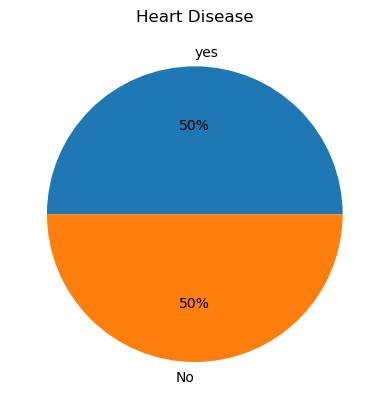

In [11]:
# Create a plot to display the percentage of the positive and negative heart disease 
labels = ['yes', 'No']
values = y_train_smote.value_counts().values

plt.pie(values, labels=labels, autopct='%1.0f%%')
plt.title('Heart Disease')
plt.show()

s suggested by the initial descriptive statistics, the dataset is likely imbalanced, meaning there are fewer patients with heart disease than without. Training a model on imbalanced data can lead to the model being biased towards the majority class and performing poorly at identifying the minority class (heart disease). SMOTE helps address this by generating synthetic heart disease cases in the training set, providing the models with more examples to learn from and improving their ability to detect heart disease.

# Model Selection and Hyperparameter Tuning

Define a dictionary of different machine learning models to be evaluated: RandomForestClassifier, XGBClassifier, MLPClassifier (a type of neural network), AdaBoostClassifier, and GradientBoostingClassifier. It also defines a dictionary of hyperparameter grids for each model. These grids contain different combinations of hyperparameter values that will be tested during tuning.

In [15]:
# Define models and parameter grids
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'MLP': MLPClassifier(random_state=42, max_iter=500),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

param_grids = {
    'RandomForest': {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5]},
    'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7]},
    'MLP': {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'alpha': [0.0001, 0.001], 'learning_rate_init': [0.001, 0.01]},
    'AdaBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0]},
    'GradientBoosting': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
}

Different models have different strengths and weaknesses. By evaluating a variety of models, the goal is to find the one that performs best at predicting heart disease on this specific dataset. Hyperparameter tuning is crucial because the performance of each model is highly dependent on its settings. GridSearchCV systematically searches through the specified parameter combinations to find the optimal ones.

# Training
Iterates through each defined model, performs GridSearchCV to find the best hyperparameters using 5-fold cross-validation and 'roc_auc' as the scoring metric, and stores the best-performing model and its training time. 

In [16]:
# Train and tune models using GridSearchCV
best_models = {}
training_times = {}
for model_name in models:
    print(f"\nTraining {model_name} with GridSearchCV...")
    start_time = time.time()
    grid_search = GridSearchCV(models[model_name], param_grids[model_name], cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_smote, y_train_smote)
    best_models[model_name] = grid_search.best_estimator_
    training_times[model_name] = time.time() - start_time
    print(f"{model_name} best parameters: {grid_search.best_params_}")


Training RandomForest with GridSearchCV...
RandomForest best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

Training XGBoost with GridSearchCV...
XGBoost best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Training MLP with GridSearchCV...
MLP best parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01}

Training AdaBoost with GridSearchCV...
AdaBoost best parameters: {'learning_rate': 0.01, 'n_estimators': 200}

Training GradientBoosting with GridSearchCV...
GradientBoosting best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


This is the core of the model training process. GridSearchCV helps in finding the model configuration that is expected to generalize best to unseen data, based on the ROC-AUC score, which is a good metric for evaluating binary classifiers, especially with imbalanced data. The training times provide an indication of the computational cost of training each model.

# Model Evaluation

Evaluates each of the best-tuned models on the unseen test set using a variety of classification metrics: accuracy, precision, F1-score, ROC-AUC, recall, and log loss.  It also computes the confusion matrix for each model.
Create a formatted table summarizing the evaluation metrics for each model, along with their training times.

In [17]:
# Evaluate models
metrics = ['accuracy', 'precision', 'f1', 'roc_auc', 'recall', 'log_loss']
results = {model: {metric: 0 for metric in metrics} for model in best_models}
confusion_matrices = {}

for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
    results[model_name]['accuracy'] = accuracy_score(y_test, y_pred)
    results[model_name]['precision'] = precision_score(y_test, y_pred, zero_division=0)
    results[model_name]['f1'] = f1_score(y_test, y_pred, zero_division=0)
    results[model_name]['roc_auc'] = roc_auc_score(y_test, y_prob)
    results[model_name]['recall'] = recall_score(y_test, y_pred, zero_division=0)
    results[model_name]['log_loss'] = log_loss(y_test, y_prob)
    confusion_matrices[model_name] = confusion_matrix(y_test, y_pred)

# Print results table
print("\n### Model Evaluation Metrics")
print("| Model            | Accuracy | Precision | F1-Score | ROC-AUC | Recall | Log Loss | Training Time (s) |")
print("|------------------|----------|-----------|----------|---------|--------|----------|-------------------|")
for model in results:
    print(f"| {model:<16} | {results[model]['accuracy']:.4f} | {results[model]['precision']:.4f} | {results[model]['f1']:.4f} | {results[model]['roc_auc']:.4f} | {results[model]['recall']:.4f} | {results[model]['log_loss']:.4f} | {training_times[model]:.2f} |")


### Model Evaluation Metrics
| Model            | Accuracy | Precision | F1-Score | ROC-AUC | Recall | Log Loss | Training Time (s) |
|------------------|----------|-----------|----------|---------|--------|----------|-------------------|
| RandomForest     | 0.8148 | 0.8235 | 0.7368 | 0.8889 | 0.6667 | 0.4244 | 12.37 |
| XGBoost          | 0.7778 | 0.7647 | 0.6842 | 0.8586 | 0.6190 | 0.4701 | 1.06 |
| MLP              | 0.7407 | 0.6522 | 0.6818 | 0.8889 | 0.7143 | 0.4152 | 3.92 |
| AdaBoost         | 0.7593 | 0.7500 | 0.6486 | 0.8175 | 0.5714 | 0.5697 | 3.65 |
| GradientBoosting | 0.7037 | 0.6471 | 0.5789 | 0.8095 | 0.5238 | 0.4965 | 3.41 |


Evaluating on the test set provides an unbiased estimate of how well each model will perform in practice. Each metric provides a different perspective on performance:

This table allows for a direct comparison of the models' performance. For heart disease prediction, high recall is often a priority to ensure that as many positive cases as possible are identified, even if it means a slightly higher number of false positives. ROC-AUC is also a robust metric for comparing models on imbalanced datasets. RandomForest and MLP appear to have the highest ROC-AUC in this evaluation.

Accuracy: Overall correct predictions.
Precision: Of those predicted with heart disease, how many actually have it? (Important to avoid false positives).
Recall (Sensitivity): Of those with heart disease, how many were correctly identified? (Crucial for not missing actual cases - false negatives).
F1-Score: A harmonic mean of precision and recall, balancing both.
ROC-AUC: Measures the ability of the model to distinguish between the two classes. A higher AUC indicates better discriminatory power.
Log Loss: Measures the performance of a classification model where the prediction is a probability. Lower log loss indicates better-calibrated probabilities.
Confusion Matrix: Breaks down the predictions into true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN), which are fundamental to understanding the trade-offs of each model.

Creat a table summarizing the confusion matrix elements (True Negatives, False Positives, False Negatives, True Positives) for each model. 

In [18]:
# Print confusion matrix table
print("\n### Confusion Matrix Metrics")
print("| Model            | TN | FP | FN | TP |")
print("|------------------|----|----|----|----|")
for model in confusion_matrices:
    tn, fp, fn, tp = confusion_matrices[model].ravel()
    print(f"| {model:<16} | {tn:<2} | {fp:<2} | {fn:<2} | {tp:<2} |")


### Confusion Matrix Metrics
| Model            | TN | FP | FN | TP |
|------------------|----|----|----|----|
| RandomForest     | 30 | 3  | 7  | 14 |
| XGBoost          | 29 | 4  | 8  | 13 |
| MLP              | 25 | 8  | 6  | 15 |
| AdaBoost         | 29 | 4  | 9  | 12 |
| GradientBoosting | 27 | 6  | 10 | 11 |


The confusion matrix provides a detailed breakdown of the model's predictions. In the context of heart disease, False Negatives (FN - predicting no disease when there is disease) are particularly concerning, as they represent missed diagnoses. False Positives (FP - predicting disease when there is none) can lead to unnecessary further testing and anxiety, but are generally considered less critical than false negatives. Analyzing these numbers for each model helps understand the types of errors each model is making. For example, RandomForest has the fewest False Negatives (7), while GradientBoosting has the most (10).

# Feature Importance

Iterates through the tree-based models (RandomForest, XGBoost, AdaBoost, GradientBoosting) and visualizes the importance of each feature as determined by the model.  Features with higher importance values contributed more to the model's predictions.

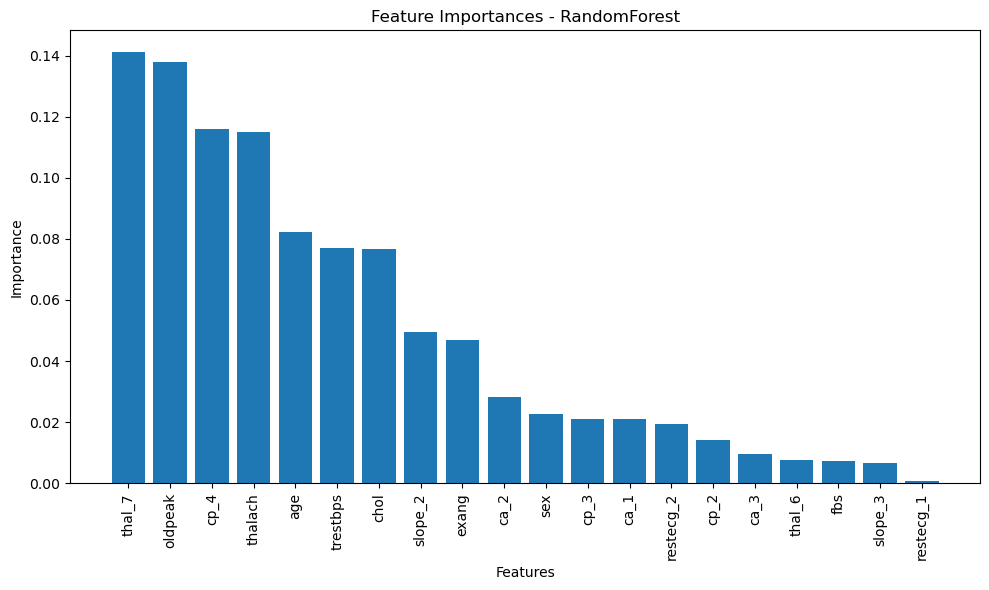

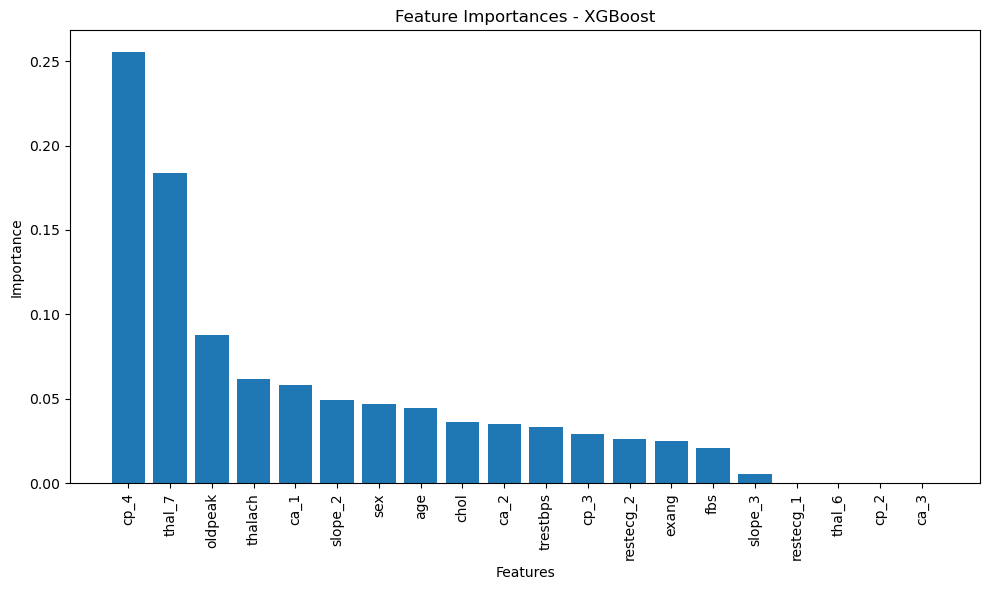

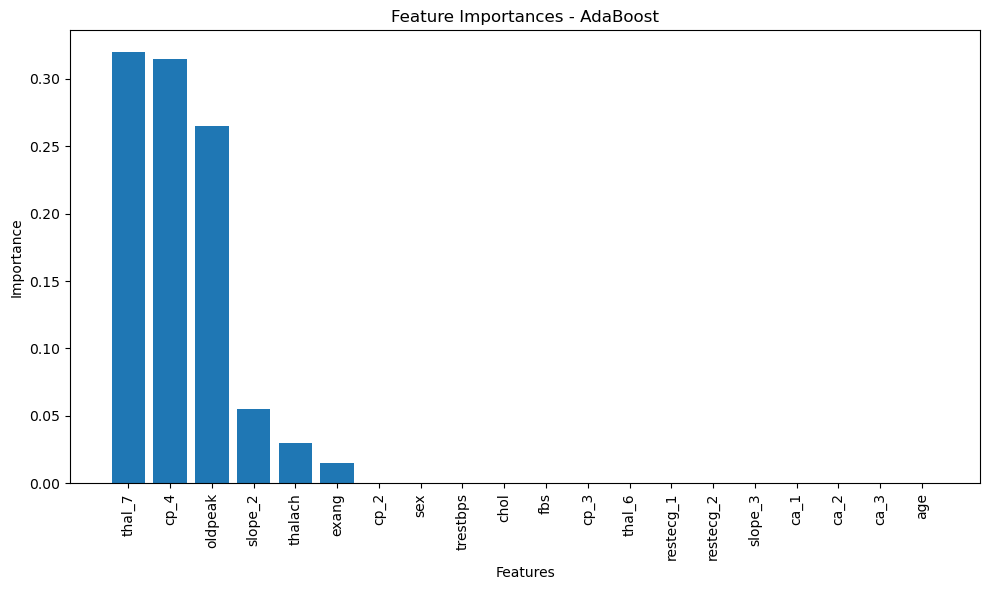

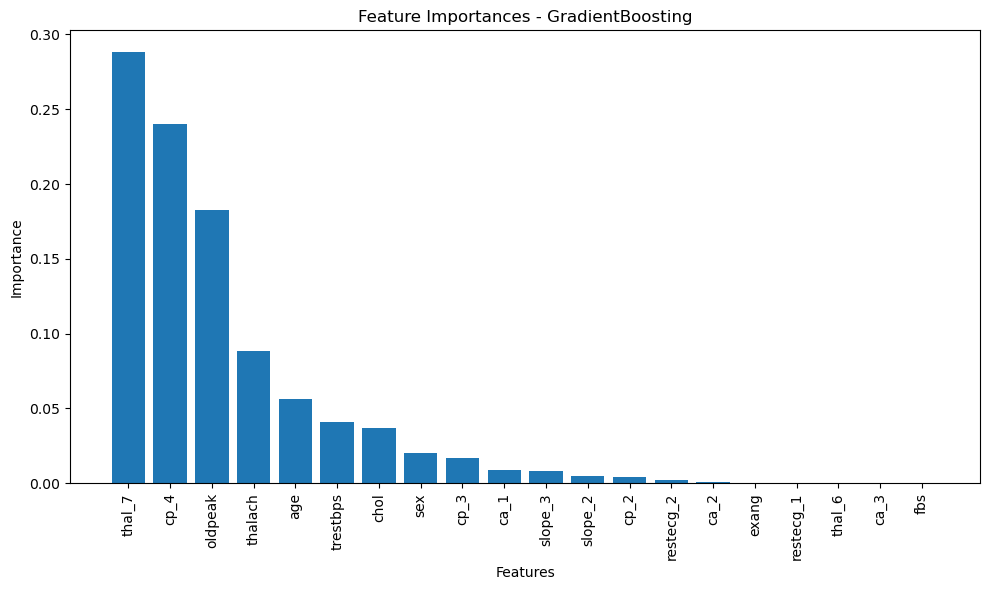

In [20]:
# Feature importance visualization
for model_name in ['RandomForest', 'XGBoost', 'AdaBoost', 'GradientBoosting']:
    if hasattr(best_models[model_name], 'feature_importances_'):
        importances = best_models[model_name].feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(10, 6))
        plt.title(f"Feature Importances - {model_name}")
        plt.bar(range(X.shape[1]), importances[indices], align="center")
        plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
        plt.xlabel("Features")
        plt.ylabel("Importance")
        plt.tight_layout()
        plt.savefig(f'feature_importance_{model_name}.png')
        plt.show()

Feature importance helps identify which patient attributes the models found most predictive of heart disease. This information can be valuable for clinical understanding and potentially for guiding data collection or further research. Features consistently ranked high across different models are likely strong indicators of heart disease.

# Explainable AI

SHAP (SHapley Additive exPlanations) library to interpret the predictions of each model.  SHAP values indicate how much each feature contributes to a prediction for a specific instance. The summary plot shows the distribution of SHAP values for each feature across the test dataset, providing insights into which features are most important globally and how they affect the prediction (positive or negative contribution). Different explainers (TreeExplainer, KernelExplainer) are used depending on the model type.

Total number of features: 20

Generating SHAP for RandomForest...
SHAP values for RandomForest are not a list, assuming single output
Shape of shap_values_positive for RandomForest: (54, 20, 2)
Shape of X_test_numeric: (54, 20)


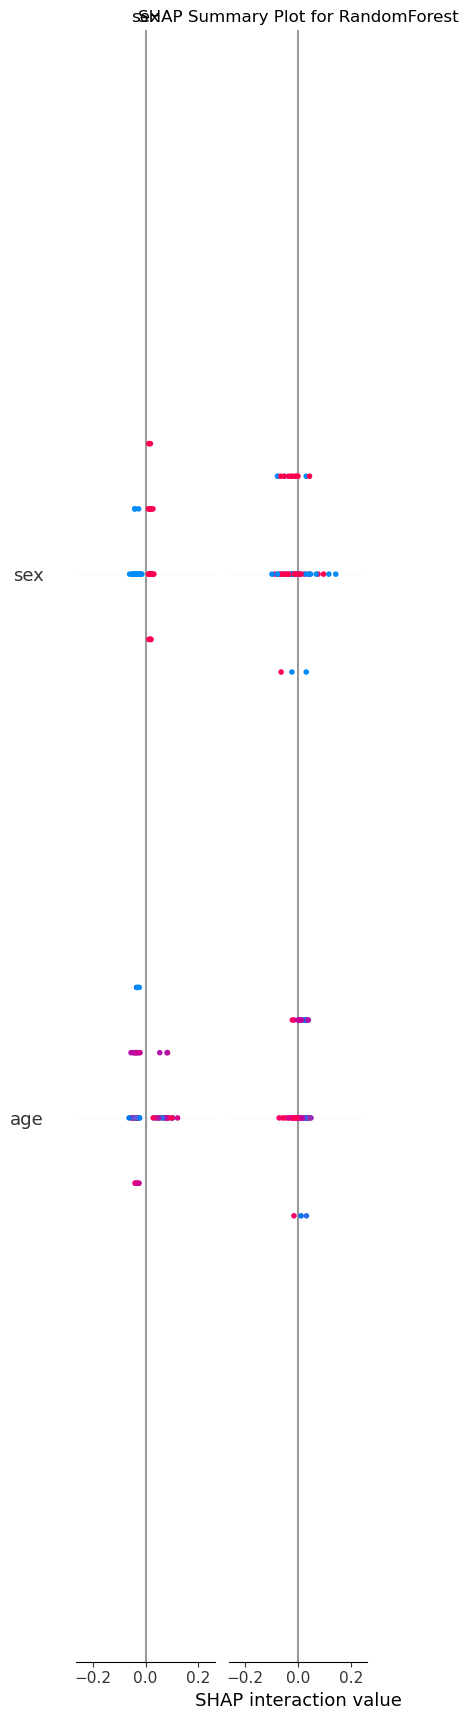


Generating SHAP for XGBoost...
SHAP values for XGBoost are not a list, assuming single output
Shape of shap_values_positive for XGBoost: (54, 20)
Shape of X_test_numeric: (54, 20)


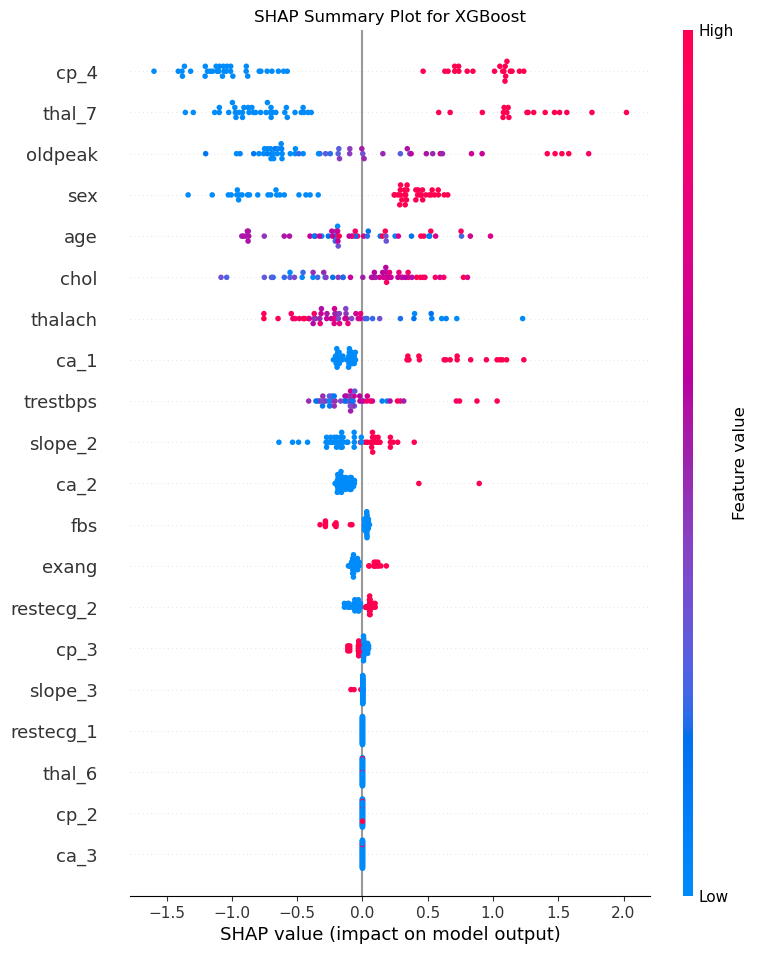


Generating SHAP for MLP...


  0%|          | 0/54 [00:00<?, ?it/s]

SHAP values for MLP are not a list, assuming single output
Shape of shap_values_positive for MLP: (54, 20, 2)
Shape of X_test_numeric: (54, 20)


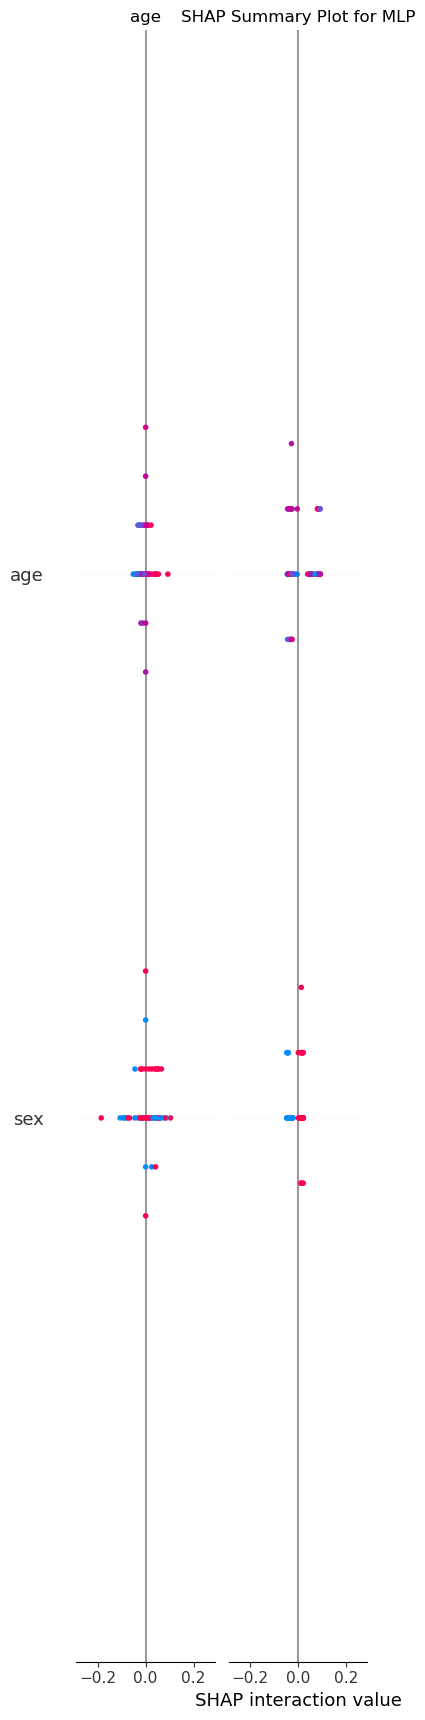


Generating SHAP for AdaBoost...


  0%|          | 0/54 [00:00<?, ?it/s]

SHAP values for AdaBoost are not a list, assuming single output
Shape of shap_values_positive for AdaBoost: (54, 20, 2)
Shape of X_test_numeric: (54, 20)


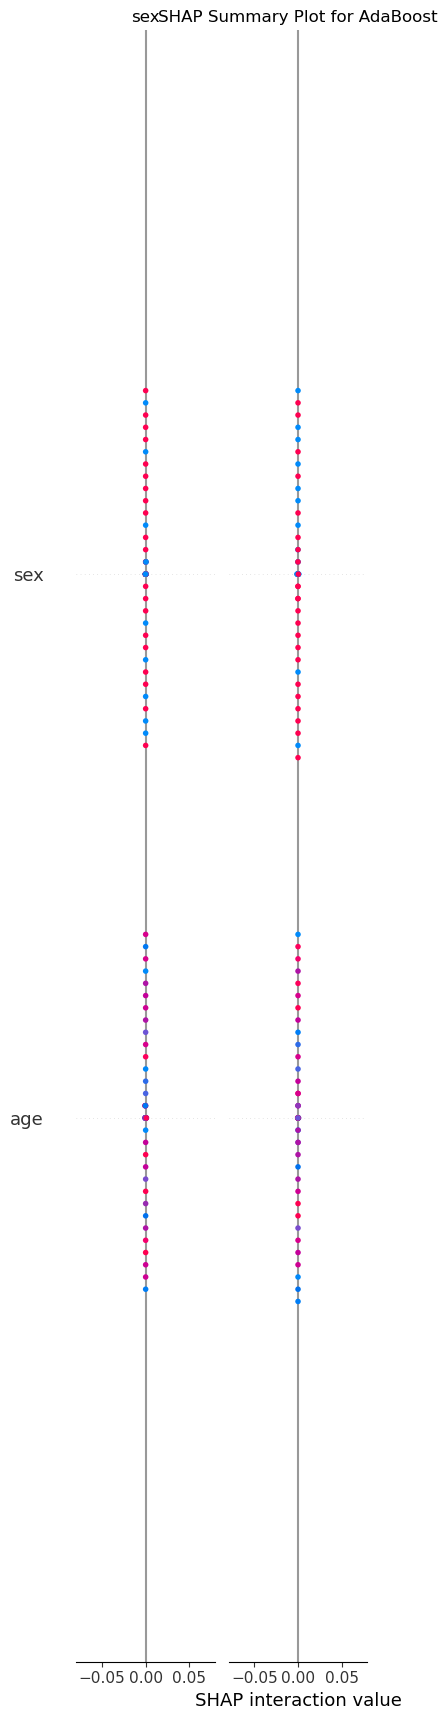


Generating SHAP for GradientBoosting...


  0%|          | 0/54 [00:00<?, ?it/s]

SHAP values for GradientBoosting are not a list, assuming single output
Shape of shap_values_positive for GradientBoosting: (54, 20, 2)
Shape of X_test_numeric: (54, 20)


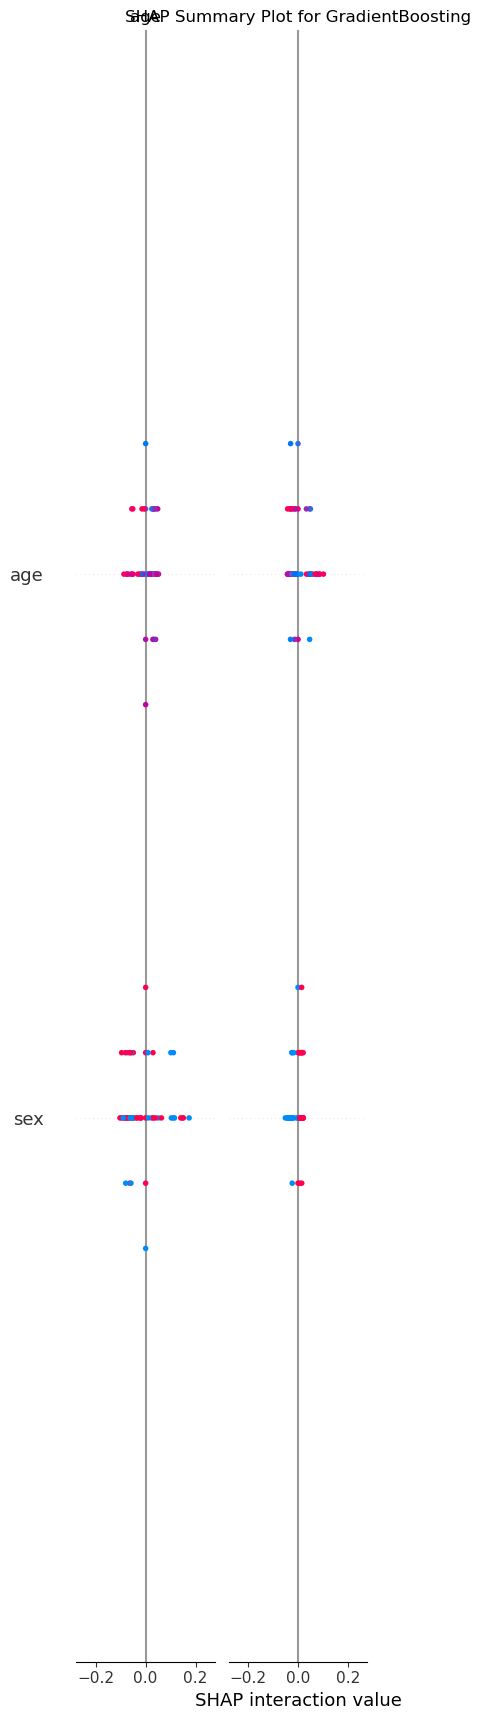

In [28]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Ensure all data is numeric
X_train_smote_numeric = X_train_smote.copy().astype(np.float64)
X_test_numeric = X_test.copy().astype(np.float64)

# Verify conversion
if not all(np.issubdtype(dtype, np.number) for dtype in X_train_smote_numeric.dtypes):
    raise ValueError("Conversion failed: All features in X_train_smote_numeric must be numeric for SHAP.")
if not all(np.issubdtype(dtype, np.number) for dtype in X_test_numeric.dtypes):
    raise ValueError("Conversion failed: All features in X_test_numeric must be numeric for SHAP.")

# Number of features (should be 13 or more after one-hot encoding)
num_features = X_test_numeric.shape[1]
print(f"Total number of features: {num_features}")

# SHAP interpretation for all models
for model_name, model in best_models.items():
    print(f"\nGenerating SHAP for {model_name}...")

    # Use appropriate explainer based on the model type
    if model_name in ['RandomForest', 'XGBoost']:
        # Tree-based models that are directly supported by TreeExplainer
        explainer = shap.TreeExplainer(model, X_train_smote_numeric, model_output="raw")
        shap_values = explainer.shap_values(X_test_numeric, check_additivity=False)
    else:
        # For AdaBoost, GradientBoosting, and MLP, use KernelExplainer
        # Sample background data to reduce computation
        background = X_train_smote_numeric.sample(min(100, len(X_train_smote_numeric)), random_state=42)
        explainer = shap.KernelExplainer(model.predict_proba, background)
        shap_values = explainer.shap_values(X_test_numeric, nsamples=100)  # Adjust nsamples for speed

    # Handle binary classification output
    if isinstance(shap_values, list):
        print(f"SHAP values for {model_name} are a list with length {len(shap_values)}")
        shap_values_positive = shap_values[1]  # Positive class (class 1)
    else:
        print(f"SHAP values for {model_name} are not a list, assuming single output")
        shap_values_positive = shap_values

    # Verify shapes
    print(f"Shape of shap_values_positive for {model_name}: {shap_values_positive.shape}")
    print(f"Shape of X_test_numeric: {X_test_numeric.shape}")
    if shap_values_positive.shape[1] != X_test_numeric.shape[1]:
        raise ValueError(f"Shape mismatch for {model_name}: shap_values_positive has {shap_values_positive.shape[1]} features, but X_test_numeric has {X_test_numeric.shape[1]} features.")

    # Plot SHAP summary for the positive class (class 1), showing all features
    shap.summary_plot(
        shap_values_positive,
        X_test_numeric,
        feature_names=X.columns,
        max_display=num_features,  # Show all features
        plot_type="dot",
        show=False
    )
    plt.title(f"SHAP Summary Plot for {model_name}")
    plt.show()  # Display the plot and keep it open

SHAP provides more detailed and interpretable insights than just feature importance. The summary plots show not only which features are important but also the direction of their effect. For example, a high SHAP value for a feature for a particular patient indicates that this feature strongly contributed to the model predicting heart disease for that patient. This can help in understanding the model's reasoning and identifying which factors are driving predictions for individual patients, which is crucial for trust and clinical adoption.

# Fairness analysis

# Gender
This identifies the protected attribute as 'sex', defines numerical representations for men and women, checks the distribution of sex in the test set, and gets the indices of men and women in the test set. 

In [29]:
# Sex
PROTECTED = "sex"
MEN = 1
WOMEN = 0
gender_dist = X_test[PROTECTED].value_counts()
print("\n### Gender Distribution in Test Set")
print(gender_dist)
men_indices = np.where(X_test[PROTECTED] == MEN)[0]
women_indices = np.where(X_test[PROTECTED] == WOMEN)[0]
print(f"Men indices: {men_indices}, No of Men = {men_indices.size}")
print(f"Women indices: {women_indices}, No of Women = {women_indices.size}")


### Gender Distribution in Test Set
sex
1    32
0    22
Name: count, dtype: int64
Men indices: [ 0  1  2  5  6  7  8 11 13 15 17 18 19 20 21 22 23 24 26 27 32 34 35 36
 38 43 46 47 48 49 52 53], No of Men = 32
Women indices: [ 3  4  9 10 12 14 16 25 28 29 30 31 33 37 39 40 41 42 44 45 50 51], No of Women = 22


Fairness analysis is critical in healthcare to ensure that models do not exhibit bias against certain demographic groups. This code sets up the analysis to compare model performance metrics specifically for male and female patients, acknowledging that heart disease can manifest differently and have different prevalence rates across sexes.

This iterates through each model and calculates various evaluation metrics (accuracy, recall, precision, positive rate, F1-score, ROC-AUC) and the confusion matrix separately for male and female patients in the test set.  It also plots the ROC curve for each sex for each model.


#### Fairness Analysis for RandomForest

Male Confusion Matrix Metrics (RandomForest):
TN=13, FP=2, FN=6, TP=11


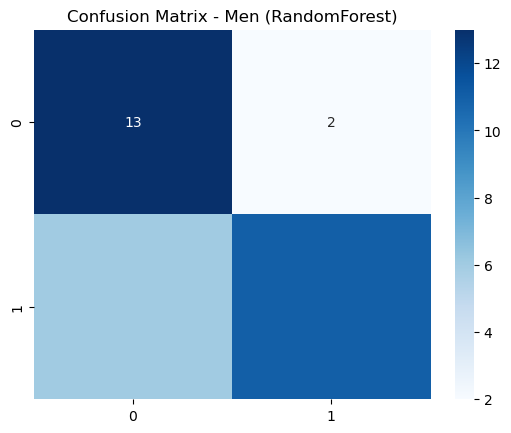

Men: Accuracy=0.75, Recall=0.65, Precision=0.85, Positive Rate=0.41, F1=0.73, ROC-AUC=0.88

Female Confusion Matrix Metrics (RandomForest):
TN=17, FP=1, FN=1, TP=3


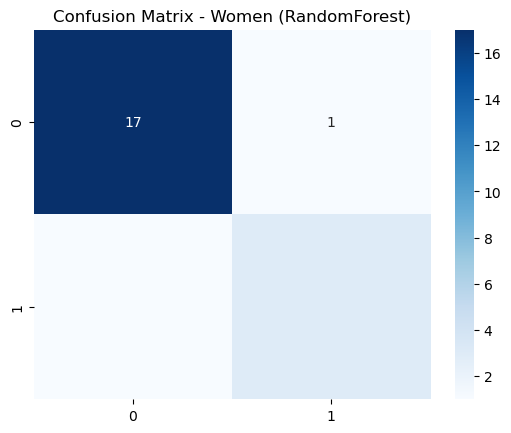

Women: Accuracy=0.91, Recall=0.75, Precision=0.75, Positive Rate=0.18, F1=0.75, ROC-AUC=0.90


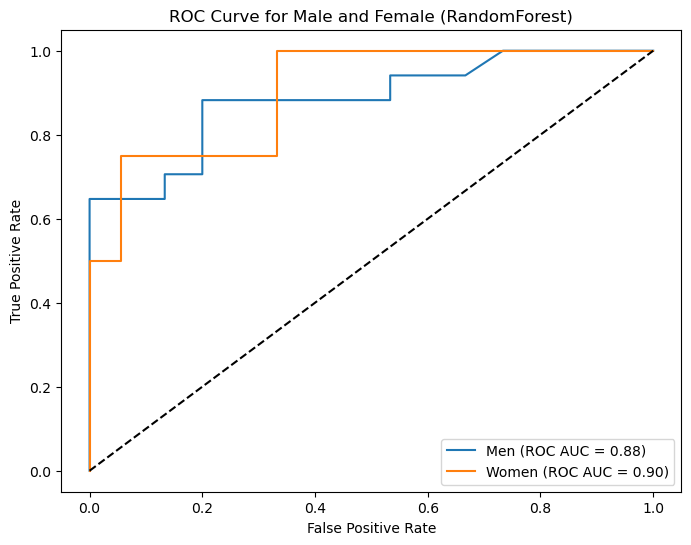


#### Fairness Analysis for XGBoost

Male Confusion Matrix Metrics (XGBoost):
TN=13, FP=2, FN=6, TP=11


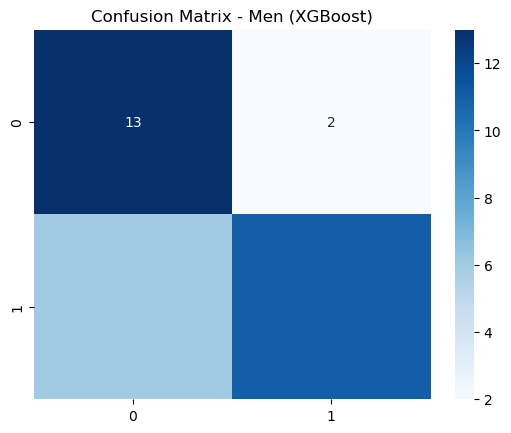

Men: Accuracy=0.75, Recall=0.65, Precision=0.85, Positive Rate=0.41, F1=0.73, ROC-AUC=0.87

Female Confusion Matrix Metrics (XGBoost):
TN=16, FP=2, FN=2, TP=2


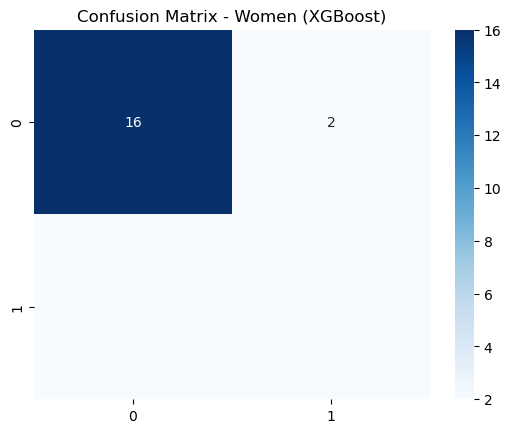

Women: Accuracy=0.82, Recall=0.50, Precision=0.50, Positive Rate=0.18, F1=0.50, ROC-AUC=0.82


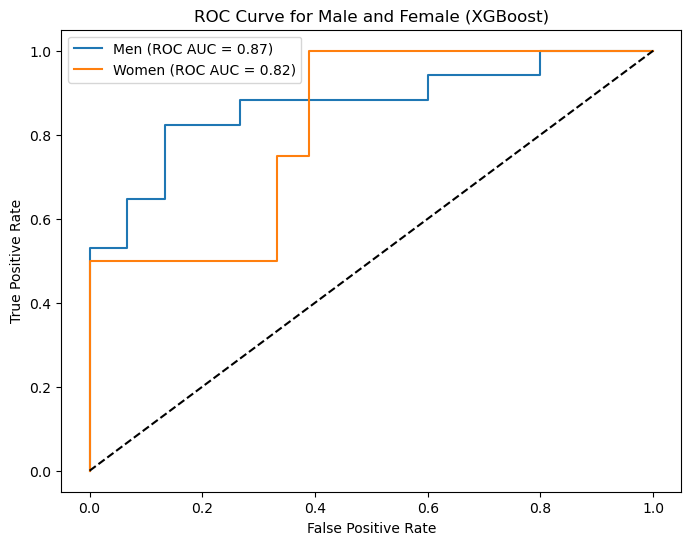


#### Fairness Analysis for MLP

Male Confusion Matrix Metrics (MLP):
TN=12, FP=3, FN=5, TP=12


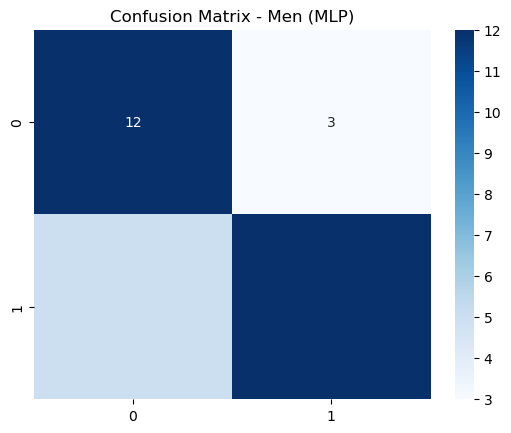

Men: Accuracy=0.75, Recall=0.71, Precision=0.80, Positive Rate=0.47, F1=0.75, ROC-AUC=0.91

Female Confusion Matrix Metrics (MLP):
TN=13, FP=5, FN=1, TP=3


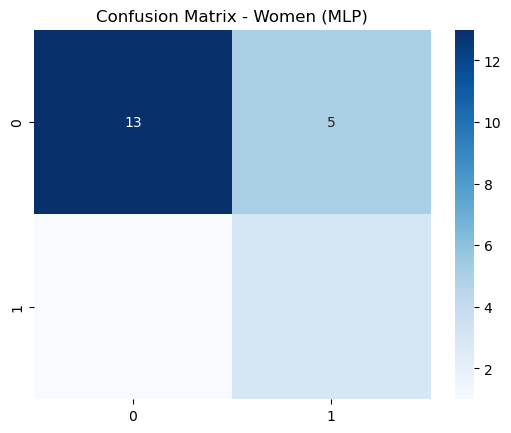

Women: Accuracy=0.73, Recall=0.75, Precision=0.38, Positive Rate=0.36, F1=0.50, ROC-AUC=0.90


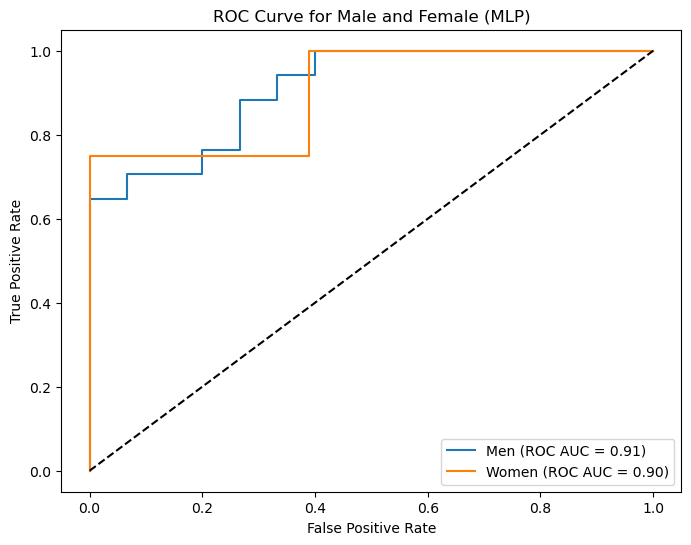


#### Fairness Analysis for AdaBoost

Male Confusion Matrix Metrics (AdaBoost):
TN=13, FP=2, FN=8, TP=9


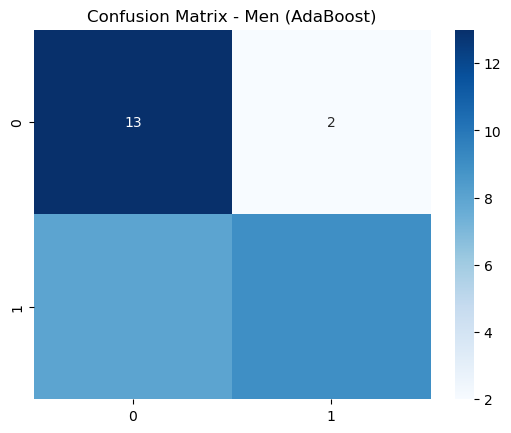

Men: Accuracy=0.69, Recall=0.53, Precision=0.82, Positive Rate=0.34, F1=0.64, ROC-AUC=0.80

Female Confusion Matrix Metrics (AdaBoost):
TN=16, FP=2, FN=1, TP=3


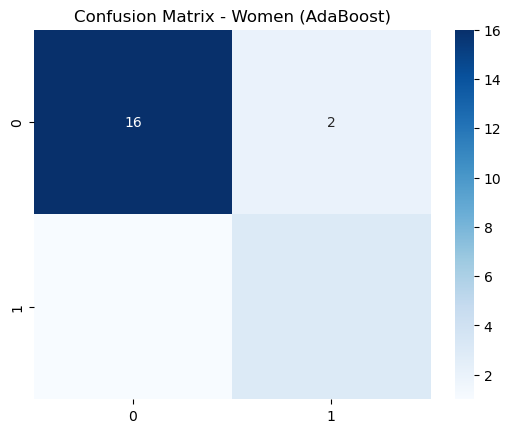

Women: Accuracy=0.86, Recall=0.75, Precision=0.60, Positive Rate=0.23, F1=0.67, ROC-AUC=0.80


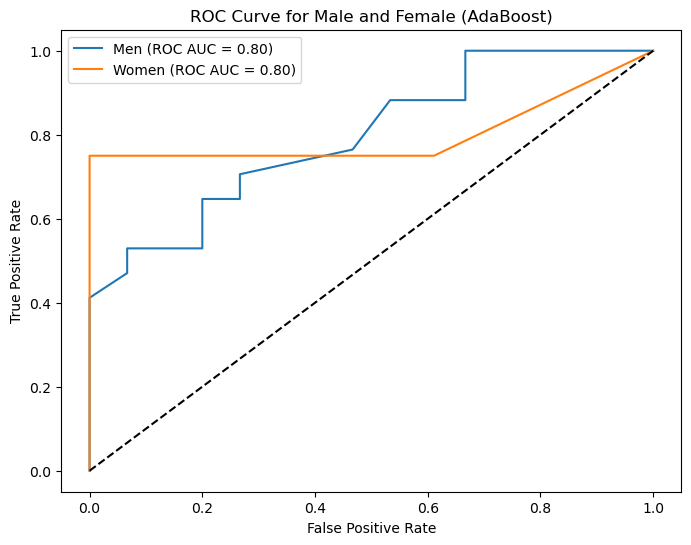


#### Fairness Analysis for GradientBoosting

Male Confusion Matrix Metrics (GradientBoosting):
TN=14, FP=1, FN=8, TP=9


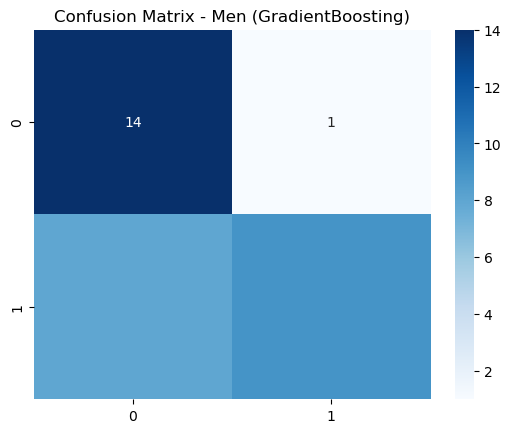

Men: Accuracy=0.72, Recall=0.53, Precision=0.90, Positive Rate=0.31, F1=0.67, ROC-AUC=0.78

Female Confusion Matrix Metrics (GradientBoosting):
TN=13, FP=5, FN=2, TP=2


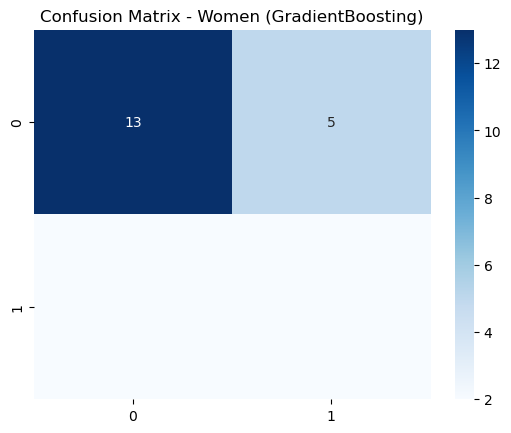

Women: Accuracy=0.68, Recall=0.50, Precision=0.29, Positive Rate=0.32, F1=0.36, ROC-AUC=0.83


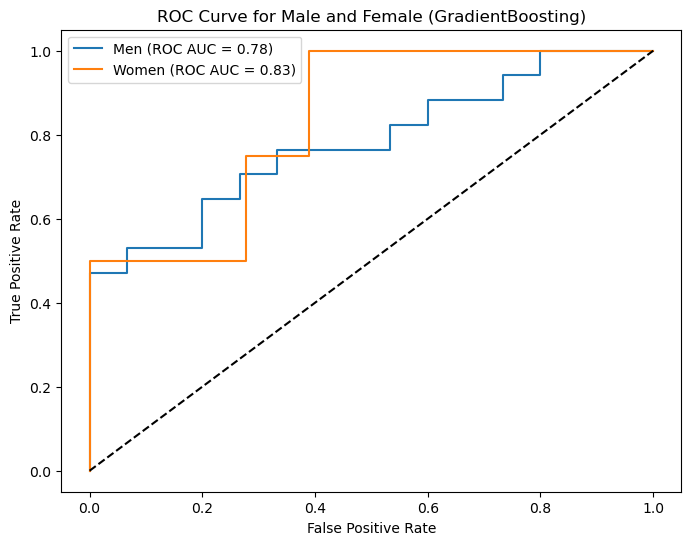

In [30]:
for model_name, model in best_models.items():
    print(f"\n#### Fairness Analysis for {model_name}")
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
    y_test_men = y_test.iloc[men_indices]
    y_test_women = y_test.iloc[women_indices]
    y_pred_men = [y_pred[i] for i in men_indices]
    y_pred_women = [y_pred[i] for i in women_indices]
    y_prob_men = [y_prob[i] for i in men_indices]
    y_prob_women = [y_prob[i] for i in women_indices]

    # Metrics for men
    cm_male = confusion_matrix(y_test_men, y_pred_men)
    tn, fp, fn, tp = cm_male.ravel()
    print(f"\nMale Confusion Matrix Metrics ({model_name}):")
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    sns.heatmap(cm_male, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Men ({model_name})')
    plt.savefig(f'cm_male_{model_name}.png')
    plt.show()
    accuracy_men = accuracy_score(y_test_men, y_pred_men)
    recall_men = recall_score(y_test_men, y_pred_men, zero_division=0)
    precision_men = precision_score(y_test_men, y_pred_men, zero_division=0)
    positive_rate_men = sum(y_pred_men) / len(y_pred_men)
    f1_men = f1_score(y_test_men, y_pred_men, zero_division=0)
    roc_auc_men = roc_auc_score(y_test_men, y_prob_men)
    print(f"Men: Accuracy={accuracy_men:.2f}, Recall={recall_men:.2f}, Precision={precision_men:.2f}, Positive Rate={positive_rate_men:.2f}, F1={f1_men:.2f}, ROC-AUC={roc_auc_men:.2f}")

    # Metrics for women
    cm_female = confusion_matrix(y_test_women, y_pred_women)
    tn, fp, fn, tp = cm_female.ravel()
    print(f"\nFemale Confusion Matrix Metrics ({model_name}):")
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    sns.heatmap(cm_female, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Women ({model_name})')
    plt.savefig(f'cm_female_{model_name}.png')
    plt.show()
    accuracy_women = accuracy_score(y_test_women, y_pred_women)
    recall_women = recall_score(y_test_women, y_pred_women, zero_division=0)
    precision_women = precision_score(y_test_women, y_pred_women, zero_division=0)
    positive_rate_women = sum(y_pred_women) / len(y_pred_women)
    f1_women = f1_score(y_test_women, y_pred_women, zero_division=0)
    roc_auc_women = roc_auc_score(y_test_women, y_prob_women)
    print(f"Women: Accuracy={accuracy_women:.2f}, Recall={recall_women:.2f}, Precision={precision_women:.2f}, Positive Rate={positive_rate_women:.2f}, F1={f1_women:.2f}, ROC-AUC={roc_auc_women:.2f}")

    # ROC curve for male and female
    fpr_men, tpr_men, _ = roc_curve(y_test_men, y_prob_men)
    fpr_women, tpr_women, _ = roc_curve(y_test_women, y_prob_women)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_men, tpr_men, label=f'Men (ROC AUC = {roc_auc_men:.2f})')
    plt.plot(fpr_women, tpr_women, label=f'Women (ROC AUC = {roc_auc_women:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Male and Female ({model_name})')
    plt.legend()
    plt.savefig(f'roc_sex_{model_name}.png')
    plt.show()

This detailed fairness analysis helps identify potential biases in the models' predictions across genders. Significant differences in metrics like recall or false negative rates between men and women would indicate that the model is not performing equally well for both groups, which could have serious implications in a clinical setting. For example, if a model has a much higher false negative rate for women, it would mean it is missing a higher proportion of heart disease cases in women compared to men. The ROC curves visually compare the trade-off between true positive rate and false positive rate for each sex.

# Age Group
Performs a similar fairness analysis, but this time based on age groups ('young', 'adult', 'old') created by categorizing the 'age' feature.  It calculates evaluation metrics and plots ROC curves for each age group for each model.


#### Fairness Metrics by Age Group for RandomForest
Age group young: Only one class present (0), ROC-AUC cannot be computed.
Age group young: Accuracy=1.00, Precision=0.00, Recall=0.00, F1=0.00, ROC-AUC=N/A, Positive Rate=0.00
Age group adult: Accuracy=0.78, Precision=0.80, Recall=0.53, F1=0.64, ROC-AUC=0.8773333333333333, Positive Rate=0.25
Age group old: Accuracy=0.91, Precision=0.86, Recall=1.00, F1=0.92, ROC-AUC=0.9, Positive Rate=0.64


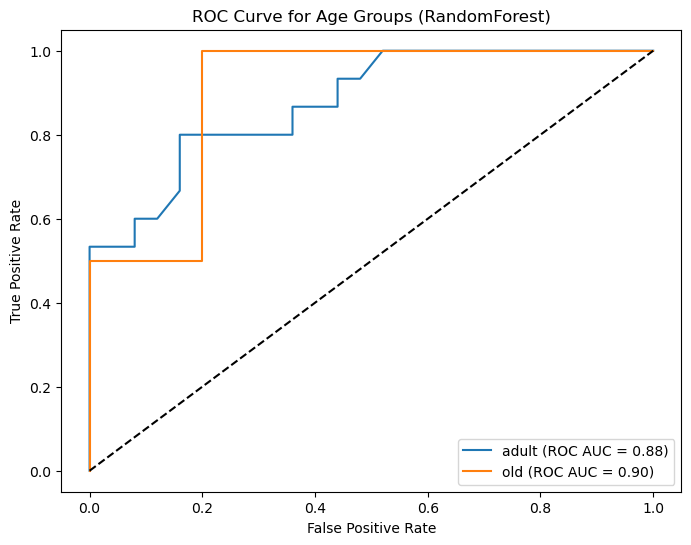


#### Fairness Metrics by Age Group for XGBoost
Age group young: Only one class present (0), ROC-AUC cannot be computed.
Age group young: Accuracy=1.00, Precision=0.00, Recall=0.00, F1=0.00, ROC-AUC=N/A, Positive Rate=0.00
Age group adult: Accuracy=0.75, Precision=0.73, Recall=0.53, F1=0.62, ROC-AUC=0.856, Positive Rate=0.28
Age group old: Accuracy=0.82, Precision=0.83, Recall=0.83, F1=0.83, ROC-AUC=0.8333333333333334, Positive Rate=0.55


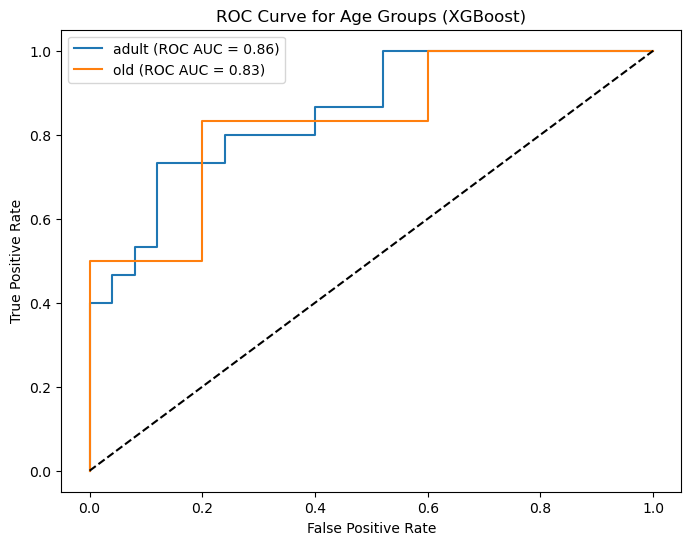


#### Fairness Metrics by Age Group for MLP
Age group young: Only one class present (0), ROC-AUC cannot be computed.
Age group young: Accuracy=1.00, Precision=0.00, Recall=0.00, F1=0.00, ROC-AUC=N/A, Positive Rate=0.00
Age group adult: Accuracy=0.75, Precision=0.67, Recall=0.67, F1=0.67, ROC-AUC=0.88, Positive Rate=0.38
Age group old: Accuracy=0.64, Precision=0.62, Recall=0.83, F1=0.71, ROC-AUC=0.9, Positive Rate=0.73


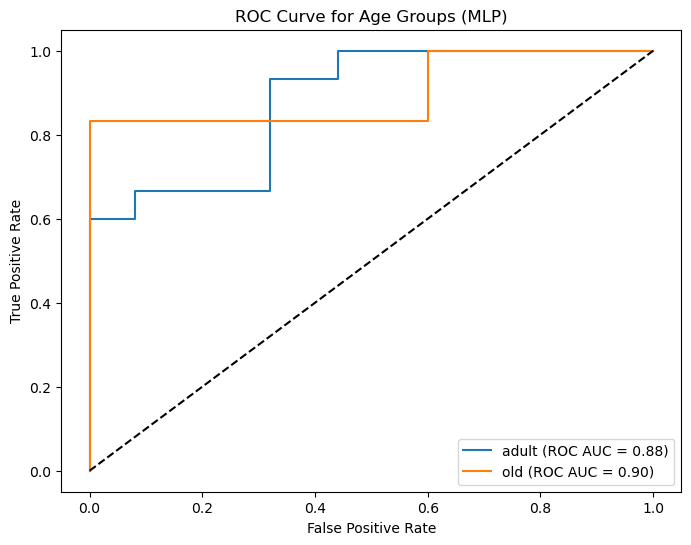


#### Fairness Metrics by Age Group for AdaBoost
Age group young: Only one class present (0), ROC-AUC cannot be computed.
Age group young: Accuracy=1.00, Precision=0.00, Recall=0.00, F1=0.00, ROC-AUC=N/A, Positive Rate=0.00
Age group adult: Accuracy=0.72, Precision=0.70, Recall=0.47, F1=0.56, ROC-AUC=0.7693333333333334, Positive Rate=0.25
Age group old: Accuracy=0.82, Precision=0.83, Recall=0.83, F1=0.83, ROC-AUC=0.9500000000000001, Positive Rate=0.55


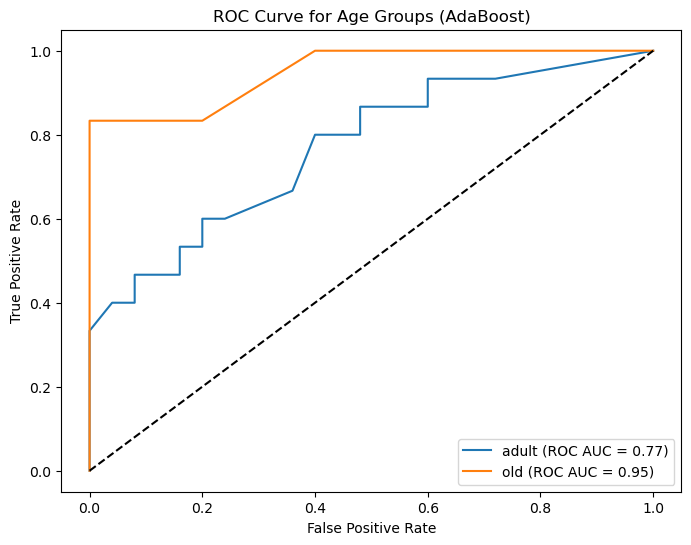


#### Fairness Metrics by Age Group for GradientBoosting
Age group young: Only one class present (0), ROC-AUC cannot be computed.
Age group young: Accuracy=1.00, Precision=0.00, Recall=0.00, F1=0.00, ROC-AUC=N/A, Positive Rate=0.00
Age group adult: Accuracy=0.75, Precision=0.73, Recall=0.53, F1=0.62, ROC-AUC=0.8186666666666667, Positive Rate=0.28
Age group old: Accuracy=0.45, Precision=0.50, Recall=0.50, F1=0.50, ROC-AUC=0.7, Positive Rate=0.55


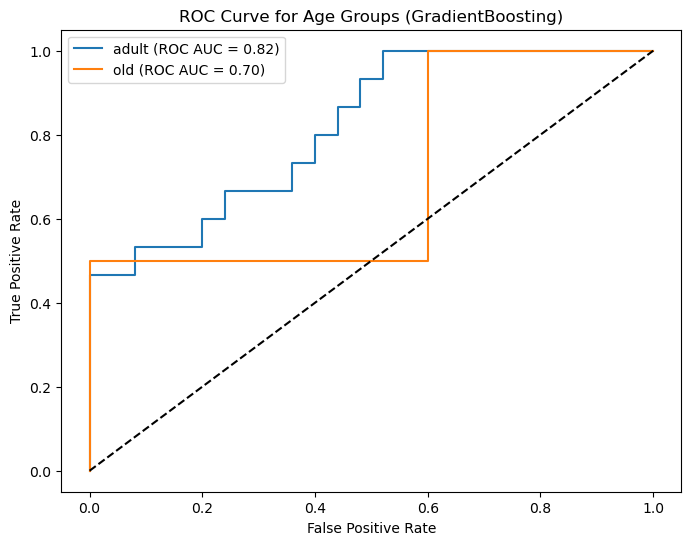

In [32]:
# Fairness analysis: Age
def categorize_age(age):
    if age < 40:
        return 'young'
    elif 40 <= age < 60:
        return 'adult'
    else:
        return 'old'

X_test_with_age_group = X_test.copy()
X_test_with_age_group['age_group'] = X_test_with_age_group['age'].apply(categorize_age)
age_groups = ['young', 'adult', 'old']

for model_name, model in best_models.items():
    print(f"\n#### Fairness Metrics by Age Group for {model_name}")

    # Prepare for ROC curve plotting
    plt.figure(figsize=(8, 6))

    for group in age_groups:
        indices = X_test_with_age_group[X_test_with_age_group['age_group'] == group].index
        if len(indices) == 0:
            print(f"Age group {group}: No samples available.")
            continue

        y_test_group = y_test.loc[indices]
        X_test_group = X_test.loc[indices]
        y_pred_group = model.predict(X_test_group)
        y_prob_group = model.predict_proba(X_test_group)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test_group)

        accuracy = accuracy_score(y_test_group, y_pred_group)
        precision = precision_score(y_test_group, y_pred_group, zero_division=0)
        recall = recall_score(y_test_group, y_pred_group, zero_division=0)
        f1 = f1_score(y_test_group, y_pred_group, zero_division=0)
        positive_rate = sum(y_pred_group) / len(y_pred_group)

        # Check if both classes are present for ROC AUC
        unique_classes = np.unique(y_test_group)
        if len(unique_classes) < 2:
            roc_auc = "N/A"
            print(f"Age group {group}: Only one class present ({unique_classes[0]}), ROC-AUC cannot be computed.")
        else:
            roc_auc = roc_auc_score(y_test_group, y_prob_group)
            # Compute ROC curve for this age group
            fpr, tpr, _ = roc_curve(y_test_group, y_prob_group)
            plt.plot(fpr, tpr, label=f'{group} (ROC AUC = {roc_auc:.2f})')

        print(f"Age group {group}: Accuracy={accuracy:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, F1={f1:.2f}, ROC-AUC={roc_auc}, Positive Rate={positive_rate:.2f}")

    # Finalize ROC curve plot for this model
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Age Groups ({model_name})')
    plt.legend()
    plt.show()  # Display the plot and keep it open

Age is a significant risk factor for heart disease. Analyzing model performance across different age groups is crucial to ensure that the models are not biased against younger or older patients. Differences in metrics across age groups could indicate that the model is not capturing the nuances of heart disease presentation or risk factors in certain age ranges. The "N/A" for ROC-AUC in the 'young' group for all models indicates that there were likely no heart disease cases (or only one class present) in the young age group in the test set, making ROC-AUC computation impossible for that group. This highlights the data distribution challenges for fairness analysis on smaller subsets.

# Overall ROC Curves and Best Model Selection
Generates and plots the overall Receiver Operating Characteristic (ROC) curve for each model on the test set.  The ROC curve illustrates the trade-off between the true positive rate and the false positive rate at various probability thresholds. The Area Under the Curve (AUC) is a single metric that summarizes the overall performance of the classifier, with a higher AUC indicating better performance. 

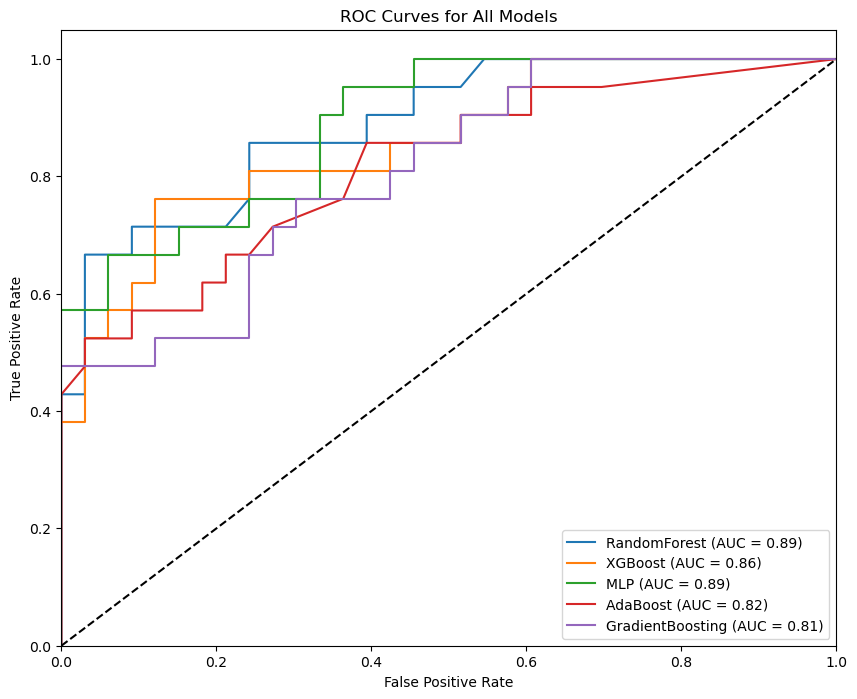

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pickle

# --- Task 1: Print ROC Curve for Each Model ---
plt.figure(figsize=(10, 8))

for model_name, model in best_models.items():
    # Get predicted probabilities for the positive class
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        # For models without predict_proba, use decision_function
        y_prob = model.decision_function(X_test)
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.savefig('roc_curves_all_models.png')  # Save the plot instead of showing it
plt.show()  

The ROC curve is a key visualization for evaluating the performance of a binary classification model. For heart disease prediction, it helps understand how well each model can distinguish between patients with and without the disease across different thresholds for making a prediction. A curve that is closer to the top-left corner indicates better performance. The AUC value provides a quantitative measure for comparing the models' overall discriminatory power.

Determines the best model based on the highest ROC-AUC score from the evaluation results.

In [36]:
# --- Task 2: Determine the Best Model ---
# Extract AUC scores from the results dictionary
auc_scores = {model: results[model]['roc_auc'] for model in results}

# Find the model with the highest AUC
best_model_name = max(auc_scores, key=auc_scores.get)
best_auc = auc_scores[best_model_name]

print(f"The best model is {best_model_name} with an AUC of {best_auc:.4f}")

The best model is RandomForest with an AUC of 0.8889


Based on the ROC-AUC metric, which is a robust measure for imbalanced datasets, this code identifies the model that is expected to perform best overall in distinguishing between patients with and without heart disease. The output indicates that RandomForest is the best model based on this criterion. This conclusion should be considered alongside the fairness analysis and other metrics (like recall) to make a final decision about which model is most suitable for a real-world heart disease prediction application.